# LSTM for WiseSight dataset

Create a deep sentiment analysis model using LSTM

## Imports

In [1]:
import os, sys
import copy
import pickle
from IPython import display

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pythainlp.ulmfit import *
from pythainlp.ulmfit import process_thai
import string, re
import random
import emoji
import io

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch import nn
from torchtext.vocab import build_vocab_from_iterator


def get_freer_gpu():
    os.system('nvidia-smi -q -d Memory |grep -A4 GPU|grep Free >gpu_free')
    memory_available = [int(x.split()[2]) for x in open('gpu_free', 'r').readlines()]
    gpu = f'cuda:{np.argmax(memory_available)}'
    if os.path.exists("gpu_free"):
        os.remove("gpu_free")
    else:
          print("The file does not exist") 
    return gpu

device = get_freer_gpu()
print(device)

cuda:0


## Load config file

In [2]:
import yaml

with open("config.yml", "r") as ymlfile:
    config = yaml.load(ymlfile)

<ipython-input-2-3cb79654d1db>:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(ymlfile)


## Load All text to create vocabulary

In [3]:
data_folder = config['data_folder']

all_text = []

# get all data from both train and test set for creating vocabulary
with open(data_folder + "train.txt") as f:
    for line in f:
        all_text.append(line.strip())
with open(data_folder + "test.txt") as f:
    for line in f:
        all_text.append(line.strip())

len(all_text)

26737

## Text Cleaning & Tokenization

In [4]:
# https://github.com/PyThaiNLP/wisesight-sentiment/blob/master/kaggle-competition/competition.ipynb
EMOJI = re.compile("["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
    u"\U00002500-\U00002BEF"  # chinese char
    u"\U00002702-\U000027B0"
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u"\U00010000-\U0010ffff"
    u"\u2640-\u2642" 
    u"\u2600-\u2B55"
    u"\u200d"
    u"\u23cf"
    u"\u23e9"
    u"\u231a"
    u"\ufe0f"  # dingbats
    u"\u3030"
                  "]+", re.UNICODE)

def replace_url(text):
    URL_PATTERN = r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))"""
    return re.sub(URL_PATTERN, 'xxurl', text)

def replace_rep(text):
    def _replace_rep(m):
        c,cc = m.groups()
        return f'{c}xxrep'
    re_rep = re.compile(r'(\S)(\1{2,})')
    return re_rep.sub(_replace_rep, text)

def process_text(text):
    #pre rules
    res = text.lower().strip()
    res = replace_url(res)
    res = replace_rep(res)
    
    PUNC  = string.punctuation
    res = ''.join([c for c in text if c not in PUNC])
    
    HASHTAG_PATTERN = r"#[a-zA-Z0-9ก-๙]+"
    res = re.sub(HASHTAG_PATTERN, "", res)
    
    MENTION_PATTERN = r"@[a-zA-Z0-9ก-๙]+"
    res = re.sub(MENTION_PATTERN, "", res)
    
    res = re.sub(EMOJI, "", res)
    
    res = [word for word in process_thai(res) if word and not re.search(pattern=r"\s+", string=word)]

    return res

In [5]:
# convert each sample into a list of tokens
all_text = [process_text(text) for text in all_text]
print(all_text[:5])

[['ประเทศ', 'เรา', 'ผลิต', 'และ', 'ส่งออก', 'ยาสูบ', 'เยอะ', 'สุด', 'ใน', 'โลก', 'จิง', 'ป่าว', 'คับ'], ['คะ'], ['อิ', 'เหี้ย', 'ออม', 'ทำ', 'กู', 'อยาก', 'กิน', 'เอ็ม', 'เค'], [], ['สวัสดี', 'วัน', 'พุธ', 'แนน', 'อะไร', 'นะ']]


## Build Vocab

In [6]:
# convert tokens into integers          
vocab = build_vocab_from_iterator(all_text, specials=["<unk>", "<pad>" ])
vocab.set_default_index(vocab["<unk>"])

In [7]:
print(vocab(['กิน', 'ข้าว', 'กัน']))
print(len(vocab))

[18, 848, 33]
27165


In [8]:
# Save vocab
# with open(config['vocab_path'], 'wb') as f:
#     pickle.dump(vocab, f, protocol=pickle.HIGHEST_PROTOCOL)

# Load vocab
# with open(config['vocab_path'], 'rb') as f:
#     vocab = pickle.load(f)

## Preparing data for training

In [9]:
def txt_to_list(txt_path):
    data_list = []
    with open(txt_path) as f:
        for line in f:
            data_list.append(line.strip())
    print(len(data_list))
    return data_list

train_text  = txt_to_list(data_folder + "train.txt")
train_label = txt_to_list(data_folder + "train_label.txt")

test_text  = txt_to_list(data_folder + "test.txt")
test_label = txt_to_list(data_folder + "test_label.txt")

24063
24063
2674
2674


## Convert string labels into int

In [10]:
LABEL_TO_INT = {'neu':0, 'pos':1, 'neg':2, 'q':3}
INT_TO_LABEL = {v:k for k,v in LABEL_TO_INT.items()}

print(train_label[:10])

train_label = [LABEL_TO_INT[label] for label in train_label]
test_label  = [LABEL_TO_INT[label] for label in test_label]

print(train_label[:10])

['neu', 'neu', 'neg', 'neu', 'neu', 'neu', 'neg', 'neu', 'neg', 'neu']
[0, 0, 2, 0, 0, 0, 2, 0, 2, 0]


## Split the training data into Train and Validation set

In [11]:
X_train, X_val, y_train, y_val = train_test_split(train_text, train_label, test_size=0.15, random_state=42, stratify = train_label)
print(len(X_train))
print(len(y_train))
print(len(X_val))
print(len(y_val))

X_test, y_test = test_text, test_label
print(len(X_test))
print(len(y_test))

20453
20453
3610
3610
2674
2674


## Use RandomOverSampler to help dealing with Imbalanced data

In [12]:
df_x_train = pd.DataFrame(X_train)

ros = RandomOverSampler(random_state=0)

# do oversampling just for the training set
df_x_train, y_train = ros.fit_resample(df_x_train, y_train)

X_train = df_x_train.loc[:, 0].tolist()

print(len(X_train))
print(len(y_train))

44556
44556


## Create custom Pytorch dataset class

In [13]:
class MyDataset(Dataset):

    def __init__(self, text_list, label_list, vocab):
        self.text_list  = text_list
        self.label_list = label_list
        self.vocab      = vocab

    def __len__(self):
        return len(self.text_list)
    
    # preprocess and tokenize the text then use vocab to convert tokens into integers
    def __getitem__(self, idx):
        text = (self.vocab(process_text(self.text_list[idx])))
        if len(text) == 0 :
            text = vocab(['<unk>'])
        return (text, self.label_list[idx])

## Creat Train, Validation and Test Dataset

In [14]:
train_dataset = MyDataset(X_train, y_train, vocab)
val_dataset   = MyDataset(X_val,  y_val, vocab)
test_dataset  = MyDataset(X_test, y_test, vocab)

In [15]:
# the sequence length of the samples are not equal
for text, label in train_dataset:
    print(text)
    print(label)
    break

[3, 254, 3927, 2, 23388, 3744, 10467, 258, 19, 175, 186, 176, 17, 279, 162, 19, 2820, 73, 718, 22, 254, 52, 379, 924, 12, 29, 54, 447, 684, 143, 6470, 104, 37, 133, 49, 97, 42, 1074, 25993, 12, 1087, 3927, 844, 1756, 74, 22956, 157, 6, 22, 4, 463, 47, 7, 5, 99, 87, 85, 133, 5379, 12, 451, 26, 16]
2


## Define Hyperparameters

In [16]:
# for nn.embedding
PAD_IDX       = vocab['<pad>'] # tell nn.embedding to ignore padding

# Training hyperparameters
batch_size    = config['batch_size']
num_epochs    = config['num_epochs']
lr            = config['lr'] # empirically set

num_workers   = config['num_workers']

In [17]:
# pad so that all sequence in the same batch has the same length with pad_sequence
def collate_batch(batch):
    label_list, text_list, length_list = [], [], []
    for (_text, _label) in batch:
        text_tensor = torch.tensor(_text, dtype=torch.int64)
        
        text_list.append(text_tensor)
        label_list.append(_label)
        length_list.append(text_tensor.size(0))  #++<-----packed padded sequences require length
    
    return torch.tensor(label_list, dtype=torch.float64), pad_sequence(text_list, padding_value=PAD_IDX, batch_first=True), torch.tensor(length_list, dtype=torch.int64)

## Creat Train, Validation and Test Dataloader

In [18]:
train_loader = DataLoader(train_dataset, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch, num_workers = num_workers)
val_loader   = DataLoader(val_dataset, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch, num_workers = num_workers)
test_loader  = DataLoader(test_dataset, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch, num_workers = num_workers)

/archive/gpu/home/users/jakrapop.a/.conda/envs/jakrapop_nlu/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [19]:
for label, text, text_length in train_loader:
    print(label)
    print(text)
    print(text_length)
    break

tensor([0., 1., 1., 1., 0., 1., 2., 3., 3., 3., 0., 2., 3., 1., 2., 1., 0., 2.,
        0., 1., 2., 3., 1., 0., 0., 1., 0., 3., 1., 0., 3., 1., 3., 0., 1., 0.,
        0., 3., 3., 1., 0., 3., 1., 2., 1., 1., 3., 1., 0., 1., 0., 3., 0., 3.,
        0., 0., 1., 2., 2., 2., 2., 1., 0., 2., 3., 0., 2., 0., 2., 1., 0., 1.,
        2., 1., 3., 2., 0., 0., 1., 1., 0., 3., 2., 0., 1., 2., 3., 3., 1., 2.,
        0., 3., 1., 0., 2., 3., 0., 3., 3., 2., 1., 0., 2., 3., 3., 2., 2., 1.,
        1., 2., 3., 3., 0., 0., 3., 0., 2., 2., 3., 2., 0., 1., 0., 3., 0., 0.,
        2., 3.], dtype=torch.float64)
tensor([[   5,  150, 2006,  ...,    1,    1,    1],
        [ 587,   12,    1,  ...,    1,    1,    1],
        [ 165,    2, 1561,  ...,    1,    1,    1],
        ...,
        [ 423,  310, 5198,  ...,    1,    1,    1],
        [  66,   84,  120,  ...,    1,    1,    1],
        [  59, 6219,    6,  ...,    1,    1,    1]])
tensor([  4,   2,  50,   3,  43,   8,  26,   9,  16,   9,  34,  37,  12,   7

## Define MySentimentModel class

In [20]:
class MySentimentModel(nn.Module):
    def __init__(self, config, vocab, INT_TO_LABEL):
        super().__init__()
        self.vocab = vocab
        input_dim = len(self.vocab)
        PAD_IDX   = self.vocab['<pad>']
        
        self.embedding = nn.Embedding(input_dim, config['embed_dim'], padding_idx=PAD_IDX)
        self.lstm = nn.LSTM(input_size   = config['embed_dim'], 
                           hidden_size   = config['hidden_dim'], 
                           num_layers    = config['num_layers'], 
                           bidirectional = config['bidirectional'], 
                           dropout       = config['dropout'],
                           batch_first   = True)
        self.fc = nn.Linear(config['hidden_dim'] * 2, config['output_dim'])
        
    def forward(self, text, text_lengths):
        # text = (batch_size, seq len)
        embedded = self.embedding(text) # (batch_size, seq_len, embed_dim)
        
        # pack the padded sequences
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'), enforce_sorted=False, batch_first=True)

        packed_output, (hn, cn) = self.lstm(packed_embedded)
        
        # concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        hn = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim = 1)
        
        return self.fc(hn)
    
    def predict(self, text:str) -> str:
        text             = self.vocab(process_text(text))
        text             = torch.tensor(text).reshape(1,-1)
        text             = self.embedding(text)
        output, (hn, cn) = self.lstm(text)
        hn               = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim = 1)
        output           = self.fc(hn)
        
        pred_class = torch.argmax(torch.softmax(output, dim=1), dim=1).detach().flatten().cpu().tolist()
        pred_class = [INT_TO_LABEL[pred] for pred in pred_class][0]
        
        return pred_class

## Define model, optimizer and criterion

In [21]:
model = MySentimentModel(config, vocab, INT_TO_LABEL).to(device)

In [22]:
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

## Define training and evaluation loop

In [23]:
def train(num_epochs, model, train_loader, val_loader, test_loader, optimizer, criterion, device):
    best_valid_loss = float('inf')

    train_losses = []
    valid_losses = []

    for epoch in range(num_epochs):

        train_loss    = _train(model, train_loader, optimizer, criterion, device)
        valid_loss, _, _ = evaluate(model, val_loader, criterion, device)
        
        print(f"EPOCH : {epoch} | Train Loss : {train_loss} | Val Loss : {valid_loss}")
        
        # for plotting
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
        # copy save model with the lowest validation loss
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_model = copy.deepcopy(model)
            best_epoch = epoch

    # get test accuracy from best model
    test_loss, y_test_pred, y_true = evaluate(best_model, test_loader, criterion, device)
    print(f"FINAL Best Model from Best Epoch {best_epoch} Test Loss = {test_loss}")
    print(classification_report(y_true, y_test_pred, target_names=['neu', 'pos', 'neg', 'q']))
    
    # save best model
    torch.save(best_model.state_dict(), "best_LSTM_weights.pth")
    
    return train_losses, valid_losses, test_loss, best_epoch, best_model, y_true, y_test_pred

def _train(model, train_loader,  optimizer, criterion, device):

    model.train()
    epoch_train_loss = 0

    for i, (label, text, text_length) in enumerate(train_loader):
        
        label       = label.to(device).long()
        text        = text.to(device) 
        text_length = text_length.to(device)

        output = model(text, text_length)
        loss   = criterion(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        
    epoch_train_loss = epoch_train_loss / len(train_loader)
    
    return epoch_train_loss

def evaluate(model, val_loader, criterion, device):

    model.eval()
    epoch_val_loss = 0
    
    all_predictions = []
    all_true_labels = []

    with torch.no_grad():
        for i, (label, text, text_length) in enumerate(val_loader):
            
            label       = label.to(device).long()   
            text        = text.to(device) 
            text_length = text_length.to(device)
            
            output = model(text, text_length)
            loss   = criterion(output, label)
            
            pred_class = torch.argmax(torch.softmax(output, dim=1), dim=1).detach().flatten().cpu().tolist()
            all_predictions.extend(pred_class)
            all_true_labels.extend(label.cpu().tolist())
            
            epoch_val_loss += loss.item()
    
    epoch_val_loss =  epoch_val_loss / len(val_loader)
    
    return epoch_val_loss, all_predictions, all_true_labels

## Train and Test the model

In [24]:
train_losses, valid_losses, test_loss, best_epoch, best_model, y_true, y_test_pred = train(num_epochs,
                                                                     model,
                                                                     train_loader,
                                                                     val_loader,
                                                                     test_loader,
                                                                     optimizer,
                                                                     criterion,
                                                                     device,
                                                                     )

EPOCH : 0 | Train Loss : 1.309769074349827 | Val Loss : 1.3371446625939731
EPOCH : 1 | Train Loss : 1.022073834536752 | Val Loss : 1.1778017981299038
EPOCH : 2 | Train Loss : 0.8605189946797652 | Val Loss : 1.0869369136876073
EPOCH : 3 | Train Loss : 0.7611880553486012 | Val Loss : 1.0381380504575268
EPOCH : 4 | Train Loss : 0.7009485789219766 | Val Loss : 1.000857803328284
EPOCH : 5 | Train Loss : 0.6609716357337712 | Val Loss : 0.9950277497028482
EPOCH : 6 | Train Loss : 0.6292546655352956 | Val Loss : 0.9737184664298748
EPOCH : 7 | Train Loss : 0.6003023339035176 | Val Loss : 0.9626492899039696
EPOCH : 8 | Train Loss : 0.5740119179545295 | Val Loss : 0.9927346048683956
EPOCH : 9 | Train Loss : 0.5526069814291247 | Val Loss : 0.958082299807976
EPOCH : 10 | Train Loss : 0.5298931276729933 | Val Loss : 0.9713896759625139
EPOCH : 11 | Train Loss : 0.5112586097423532 | Val Loss : 1.013009406369308
EPOCH : 12 | Train Loss : 0.49070214021171743 | Val Loss : 0.9877110246954293
EPOCH : 13 | 

/archive/gpu/home/users/jakrapop.a/.conda/envs/jakrapop_nlu/lib/python3.9/site-packages/torch/nn/modules/rnn.py:772: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, batch_sizes, hx, self._flat_weights, self.bias,


FINAL Best Model from Best Epoch 9 Test Loss = 0.9454598001071385
              precision    recall  f1-score   support

         neu       0.76      0.57      0.65      1456
         pos       0.42      0.58      0.48       478
         neg       0.64      0.78      0.70       683
           q       0.27      0.46      0.34        57

    accuracy                           0.62      2674
   macro avg       0.52      0.59      0.54      2674
weighted avg       0.66      0.62      0.63      2674



## Confusion Matrix

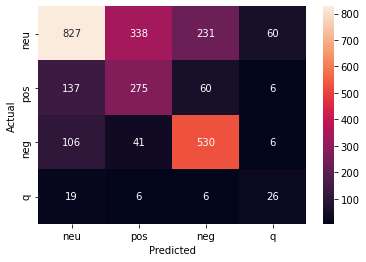

In [25]:
conf_mat = confusion_matrix(y_true , y_test_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['neu', 'pos', 'neg', 'q'], yticklabels=['neu', 'pos', 'neg', 'q'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()